<a href="https://colab.research.google.com/github/elliemci/agents/blob/main/email_processing_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph workflow for email processing

In [ ]:
!pip install langgraph langchain_openai langchain_huggingface

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/AgentsCourse

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/AgentsCourse


Email processing consists of reading incoming emails, classifying them as legit or spam, draft a preliminaty response of legit emails, sending prelim responce for validation and edit.

In [ ]:
import os

from typing import TypedDict, List, Dict, Any, Optional  # typing module introduces hints/ type annotations, which works at runtime by implementing __getitem__() in the metaclass and as a offline type checker
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

from google.colab import userdata

openai_api_key = userdata.get('OPENAI_API_KEY')
model = ChatOpenAI(model="gpt-4o-mini", api_key=openai_api_key, temperature=0)

## States

State should be comprehensive enough to track all the important information. The email processing need to track:
* email being processed
* email class legit or spam
* classification reason
* draft response
* conversation history


In [ ]:
class EmailState(TypedDict):
    email: Dict[str, Any]           # attribute that stores the actual email data as a dictionary with keys like "sender", "recipient", "subject", "body", etc. with keys being strings and values of any type
    is_spam: Optional[bool]         # attribute can be either be "True", "Falase" or "None" in not yet classified
    spam_reason: Optional[str]      # attribute that provides a reason for the classificaition, eg "contains phising links"; Options[str] means it can contain a strin or None
    email_category: Optional[str]   # attribute that stores the categoty or label of assined to email like "innquiry", "complaint", "notification"
    draft_response: Optional[str]   # preliminaty draft of the response; [] mean no new syntax needs to be added to the language
    messages: List[Dict[str, Any]]  # conversational history as a list of dictionaries, where each dictionary represent a message in the conversation

## Nodes

In [ ]:
def read_email(state: EmailState):   # input parameter 'state', hit ": EmailState" TypeDict; Type Hinting helps code editors and static analysis tools
  email = state["email"]             # extract the email data from state dictionary
  print(f"Agent is processing an email from {email['sender']} with subject: {email['subject']}")
  return {}                          # return an empty sictionary a placehoder for future functionality

In [ ]:
def classify_email(state: EmailState):
  """ Function that figure out state updates and returns them in a dictionary.
      The framework will take these updated and merge them into the existing state
      to replfect the changes made."""

  email = state["email"]

  prompt = f"""
  As an agent, analyze this email and determine if it is spam or legitimate and should be bring to the user attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only reurn the answer
Answer :
    """
  # create a conversation sequence of messages list containing HummanMessage object, which is a LangChain way of encapsulating a message from human uset to the LLM
  messages = [HumanMessage(content=prompt)]
  # send the messages list containing the prompt to the LLM for processing
  response = model.invoke(messages)
  # extracting and lowercasing the llm response
  response_text = response.content.lower()
  print(response_text)

  # check if substring "spam" is present in responce
  is_spam = "spam" in response_text and "ham" not in response_text

  # if the email is not spam the conversation history is updated with the prompt and the LLM's response
  if not is_spam:
      new_messages = state.get("messages", []) + [
          {"role": "user", "content": prompt},
          {"role": "assistant", "content": response.content}
      ]
  # if the message is not spam, the conversation histoty retains its original value from state
  else :
      new_messages = state.get("messages", [])

  # updates to specific keys
  return {
      "is_spam": is_spam,
      "messages": new_messages
  }

In [ ]:
def handle_spam(state: EmailState):
  print(f"Agent is handling a spam email from {state['email']['sender']}")
  print("The email has been moved to the spam folder.")
  return {}

In [ ]:
def drafting_response(state: EmailState):
  """Function takes an email, crafts a prompt asking a LLM to draft a response,
     updates the conversation history, and returns the LLM's response and updated history."""
  # extract the email data
  email = state["email"]
  print(f"Agent is drafting a response for an email from {email['sender']}")

  # create a prompt including a context with email sender, subject and body
  prompt = f"""
  As an agent, draft a polite preliminary response to this email.

  Email:
  From: {email['sender']}
  Subject: {email['subject']}
  Body: {email['body']}

  Draft a professional response that will be review before sending.
  """

  # create a messages object containin the prompt formated as it came from human user
  messages = [HumanMessage(content=prompt)]
  response = model.invoke(messages)

  # update conversation history by retriving the existing messages and appending
  # two new messages the prompt and the language model's response
  new_messages = state.get("messages", []) + [
      {"role": "user", "content": prompt},
      {"role": "assistant", "content": response.content}
  ]

  return {
      "draft_response": response.content,
      "messages": new_messages
      }

In [ ]:
def notify(state: EmailState):
    email = state["email"]

    print("\n" + "="*50)
    print(f"You've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")

    return {}

## Routing Logic

In [ ]:
def route_email(state: EmailState) -> str:
  """ Define routing logic, absed on the classification.
      The return value must match one of the keys of the conditional edges mapping"""
  if state["is_spam"]:
    return "spam"
  else:
    return "legitimate"

# Graph

In [ ]:
email_graph = StateGraph(EmailState)

# Nodes

NB: Each time the cell is run, it attempts to add the same nodes again, leading to the ValueError.

In [ ]:
email_graph.add_node("read_email", read_email) # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email) # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("drafting_response", drafting_response)
email_graph.add_node("notify", notify)

# Edges

In [ ]:
email_graph.add_edge(START, "read_email")             # after starting, read email
email_graph.add_edge("read_email", "classify_email")  # after reading, classify

# add conditional edges
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "drafting_response"
    }
)

# add final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("drafting_response", "notify")
email_graph.add_edge("notify", END)

# Compile

In [ ]:
compiled_graph = email_graph.compile()

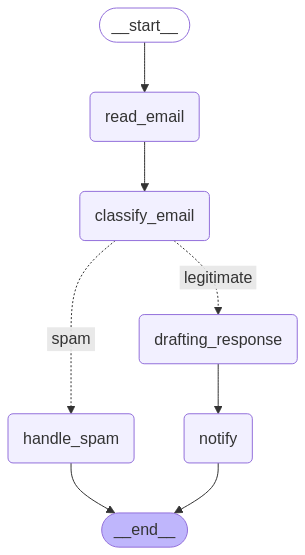

In [ ]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## Test

In [ ]:
# Example emais for testing
legitimate_email = {
    "sender": "Patrick Holen",
    "subject": "Performance",
    "body": "CONCERT WEEK!!! All Bands and Percussion Ensemble have a concert on Wednesday! Here is the plan for Concert Day 8am- Percussion Students arrive to set up stage, work with Mr. Johnson 9:15am Wind Ensemble Rehearses their set with Percussion Students 9:45am Symphonic Band Rehearses with Percussion Students 10:05am rehearsal ends 6:30pm Sound Check (and to final run through with videos) (ATTIRE IS CONCERT BLACK) Symphonic Band AND Wind Ensemble report to theater w/ Instruments After Soundcheck, instruments and music are to be stored in 1410 7:00pm Concert Band Reports to 1412 7:25pm Concert Band lines up in hallway to enter stage 7:30pm Concert Begins. 8:30pm Concert Ends (approximately)"""
}

spam_email = {
    "sender": "TurboDebt",
    "subject": "Regarding Your Current Credit Card Debt Relief Options",
    "body": "Fast-Track to financial stability."

}

# process legitimate email
print("\nProcessing legtimate email.")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email.")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
})


Processing legtimate email.
Agent is processing an email from Patrick Holen with subject: Performance
ham
Agent is drafting a response for an email from Patrick Holen

You've received an email from Patrick Holen.
Subject: Performance

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Performance

Dear Patrick,

Thank you for the detailed schedule for Concert Week! I appreciate the clarity and organization you've provided for the day’s events. 

I will ensure that all students are informed of the timeline and attire requirements. If there are any additional details or changes as we approach the concert, please let me know.

Looking forward to a successful performance!

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]  


Processing spam email.
Agent is processing an email from TurboDebt with subject: Regarding Your Current Credit Card Debt Relief Options
spam
Agent is handling a spam email from Turbo

## Inspecting with Langfuse